In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.8 MB/s eta 0:00:00


## Importing Libraries

In [45]:
# Importing Libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import learning_curve

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings

# Suppress warnings
warnings.filterwarnings('ignore')




##### Load the dataset



In [39]:
data = pd.read_csv('/content/drive/MyDrive/datasets/Sales.csv')

In [40]:
data.shape

(8523, 12)

In [41]:
data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

###EDA

In [18]:
# Display first few rows
display(data.head())

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [26]:
# Checking for missing values
print(f"Missing Values in Each Column:\n{data.isnull().sum()}")


Missing Values in Each Column:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [19]:
# Check for duplicate entries
duplicates = data.duplicated().sum()
print(f'Duplicate Rows: {duplicates}')

Duplicate Rows: 0


In [20]:
# Data types and non-null counts
print('\nData Information:')
data.info()



Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [42]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Data Cleaning and Preprocessing


### Handling Missing Values

#### Missing Values in 'Item_Weight'

In [43]:
# Handling missing values in 'Item_Weight' using KNN Imputer
# Select numerical features for imputation
imputer_features = ['Item_Weight', 'Item_MRP', 'Item_Visibility']

# Prepare data for imputation
imputer_data = data[imputer_features]

# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Fit and transform the data
imputed_data = knn_imputer.fit_transform(imputer_data)

# Assign imputed data back to the DataFrame
data['Item_Weight'] = imputed_data[:, 0]
print(f"Missing 'Item_Weight' values after imputation: {data['Item_Weight'].isnull().sum()}")



Missing 'Item_Weight' values after imputation: 0


#### Missing Values in 'Outlet_Size'


In [46]:
# Handling missing values in 'Outlet_Size' using RandomForestClassifier

# Create a separate DataFrame for rows with and without missing 'Outlet_Size'
outlet_size_missing = data[data['Outlet_Size'].isnull()].copy()
outlet_size_not_missing = data.dropna(subset=['Outlet_Size']).copy()

# Features to use for prediction
features = ['Outlet_Location_Type', 'Outlet_Type', 'Outlet_Identifier', 'Item_Type']

# Encode categorical variables separately for each column
from sklearn.preprocessing import LabelEncoder

# Dictionaries to hold LabelEncoders for each column
le_dict = {}

# Fit LabelEncoders on combined data to capture all categories
for col in features:
    le = LabelEncoder()
    combined_data = pd.concat([outlet_size_not_missing[col], outlet_size_missing[col]], axis=0)
    le.fit(combined_data)
    le_dict[col] = le
    outlet_size_not_missing[col] = le.transform(outlet_size_not_missing[col])
    outlet_size_missing[col] = le.transform(outlet_size_missing[col])

# Prepare data
X_outlet = outlet_size_not_missing[features]
y_outlet = outlet_size_not_missing['Outlet_Size']

# Encode target variable with a new LabelEncoder
le_outlet_size = LabelEncoder()
y_outlet_encoded = le_outlet_size.fit_transform(y_outlet)

# Train a RandomForestClassifier to predict 'Outlet_Size'
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_outlet, y_outlet_encoded)

# Prepare test data (already encoded)
X_missing = outlet_size_missing[features]

# Predict missing 'Outlet_Size'
predicted_sizes_encoded = rfc.predict(X_missing)

# Inverse transform to get original categories
predicted_sizes = le_outlet_size.inverse_transform(predicted_sizes_encoded)
outlet_size_missing['Outlet_Size'] = predicted_sizes

# Combine the data
data = pd.concat([outlet_size_not_missing, outlet_size_missing], axis=0)

# Verifying that no missing Outlet_Size values remain
print(f"Missing 'Outlet_Size' values after imputation: {data['Outlet_Size'].isnull().sum()}")


Missing 'Outlet_Size' values after imputation: 0


### Correcting 'Item_Visibility' Zeros


In [47]:

# Replace zeros with mean visibility
data['Item_Visibility'].replace(0, data['Item_Visibility'].mean(), inplace=True)

### Standardizing 'Item_Fat_Content'


In [50]:
# Standardize 'Item_Fat_Content'
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace(
    {'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}
)

# Adjust 'Item_Fat_Content' for non-consumable items
data.loc[data['Item_Identifier'].str.startswith('NC'), 'Item_Fat_Content'] = 'Non-Edible'

### Feature Engineering


#### Creating 'Years_Operational'


In [51]:
# Calculate the number of years the outlet has been operational
data['Years_Operational'] = 2013 - data['Outlet_Establishment_Year']

#### Creating 'Item_Type_Combined'


In [52]:
# Create 'Item_Type_Combined' feature
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[:2])
data['Item_Type_Combined'] = data['Item_Type_Combined'].map(
    {'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'}
)

#### Creating 'Price_per_Unit_Weight'


In [53]:
# Create 'Price_per_Unit_Weight' feature
data['Price_per_Unit_Weight'] = data['Item_MRP'] / data['Item_Weight']

#### Binning 'Item_MRP'


In [54]:
# Bin 'Item_MRP' into tiers
data['Item_MRP_Tier'] = pd.cut(
    data['Item_MRP'],
    bins=[0, 69, 136, 203, data['Item_MRP'].max()],
    labels=['Low', 'Medium', 'High', 'Very High'],
)

## Encoding Categorical Variables


In [55]:
# List of categorical columns
categorical_cols = [
    'Item_Fat_Content',
    'Outlet_Location_Type',
    'Outlet_Size',
    'Outlet_Type',
    'Item_Type_Combined',
    'Item_MRP_Tier',
]

# One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Label Encoding 'Outlet_Identifier' and 'Item_Type'
le = LabelEncoder()
data['Outlet_Identifier'] = le.fit_transform(data['Outlet_Identifier'])
data['Item_Type'] = le.fit_transform(data['Item_Type'])

## Preparing the Final Dataset


In [56]:
# Drop unnecessary columns
data.drop(['Item_Identifier', 'Outlet_Establishment_Year'], axis=1, inplace=True)

# Separate features and target variable
X = data.drop('Item_Outlet_Sales', axis=1)
y = data['Item_Outlet_Sales']

## Feature Scaling


In [57]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

## Splitting the Data


In [58]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Model Training and Evaluation


### Model Evaluation Function


In [59]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    metrics = {}
    metrics['Train R2'] = r2_score(y_train, y_train_pred)
    metrics['Test R2'] = r2_score(y_test, y_test_pred)
    metrics['Train RMSE'] = np.sqrt(mean_squared_error(y_train, y_train_pred))
    metrics['Test RMSE'] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    metrics['Train MAE'] = mean_absolute_error(y_train, y_train_pred)
    metrics['Test MAE'] = mean_absolute_error(y_test, y_test_pred)

    # Print metrics
    print(f"Model: {model.__class__.__name__}")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    print('-' * 40)

    # Return metrics
    return metrics

### Training Different Models


In [60]:
# Initialize models
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    XGBRegressor(eval_metric='rmse'),
    LGBMRegressor(),
    CatBoostRegressor(verbose=0),
]

# Evaluate each model
model_metrics = {}
for model in models:
    print(f"Training {model.__class__.__name__}...")
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    model_metrics[model.__class__.__name__] = metrics

Training LinearRegression...
Model: LinearRegression
Train R2: 0.5587
Test R2: 0.5795
Train RMSE: 1136.2109
Test RMSE: 1096.4353
Train MAE: 840.0415
Test MAE: 827.4346
----------------------------------------
Training Ridge...
Model: Ridge
Train R2: 0.5587
Test R2: 0.5795
Train RMSE: 1136.2113
Test RMSE: 1096.4379
Train MAE: 840.0206
Test MAE: 827.4494
----------------------------------------
Training Lasso...
Model: Lasso
Train R2: 0.5586
Test R2: 0.5794
Train RMSE: 1136.2593
Test RMSE: 1096.5276
Train MAE: 839.6691
Test MAE: 827.6425
----------------------------------------
Training DecisionTreeRegressor...
Model: DecisionTreeRegressor
Train R2: 1.0000
Test R2: 0.1514
Train RMSE: 0.0000
Test RMSE: 1557.5391
Train MAE: 0.0000
Test MAE: 1101.7932
----------------------------------------
Training RandomForestRegressor...
Model: RandomForestRegressor
Train R2: 0.9370
Test R2: 0.5688
Train RMSE: 429.2540
Test RMSE: 1110.2359
Train MAE: 295.5524
Test MAE: 793.3455
-------------------------

## Hyperparameter Tuning


### Hyperparameter Grid for CatBoostRegressor


In [61]:
# Define parameter grid
cat_param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 500],
    'l2_leaf_reg': [1, 3, 5],
}

# Initialize CatBoostRegressor
cat_model = CatBoostRegressor(verbose=0)

# Initialize GridSearchCV
from sklearn.model_selection import GridSearchCV

cat_grid = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# Fit the model
cat_grid.fit(X_train, y_train)

# Best parameters
print("Best parameters for CatBoostRegressor:")
print(cat_grid.best_params_)

Best parameters for CatBoostRegressor:
{'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.05}


### Evaluate the Tuned Model


In [62]:
# Best estimator
best_cat_model = cat_grid.best_estimator_

# Evaluate
evaluate_model(best_cat_model, X_train, y_train, X_test, y_test)

Model: CatBoostRegressor
Train R2: 0.6041
Test R2: 0.6211
Train RMSE: 1076.1006
Test RMSE: 1040.7172
Train MAE: 758.3063
Test MAE: 747.7749
----------------------------------------


{'Train R2': 0.6041142469108151,
 'Test R2': 0.6211213334489009,
 'Train RMSE': 1076.1006372012655,
 'Test RMSE': 1040.7171659461583,
 'Train MAE': 758.3063385192505,
 'Test MAE': 747.7749342819535}

## Feature Importance


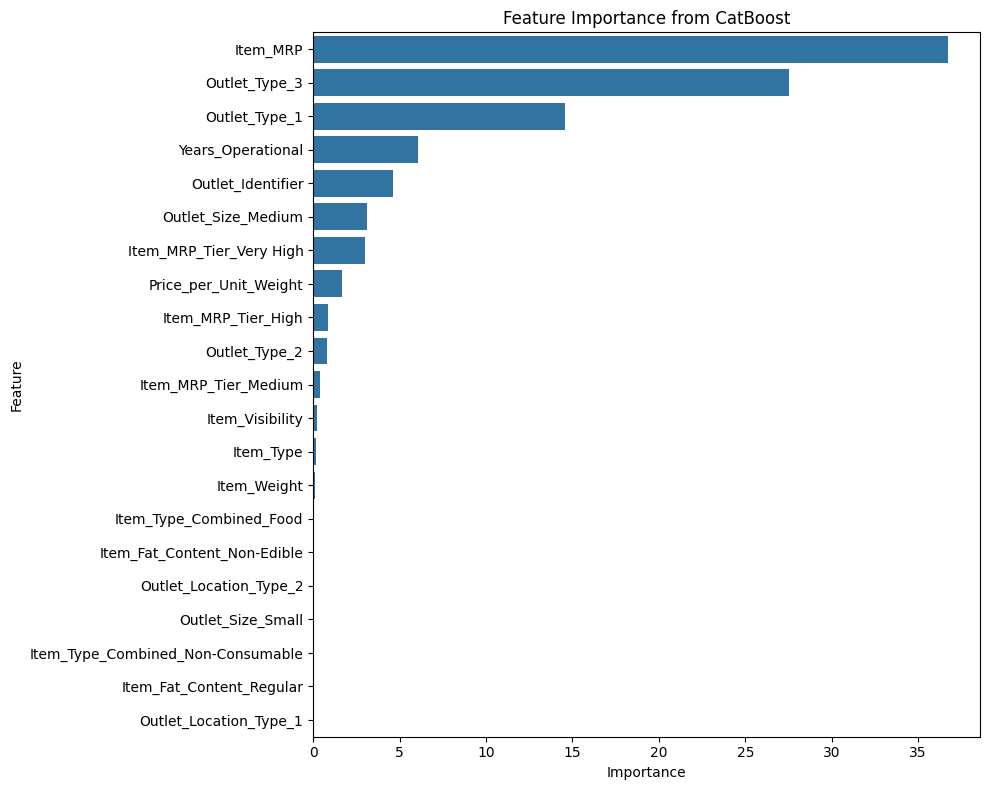

In [63]:
# Feature importance from CatBoost
feature_importance = best_cat_model.get_feature_importance()

# Get feature names
feature_names = X.columns

# Create a DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance,
})

# Sort by importance
feat_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df)
plt.title('Feature Importance from CatBoost')
plt.tight_layout()
plt.show()

## Actual vs. Predicted Plot


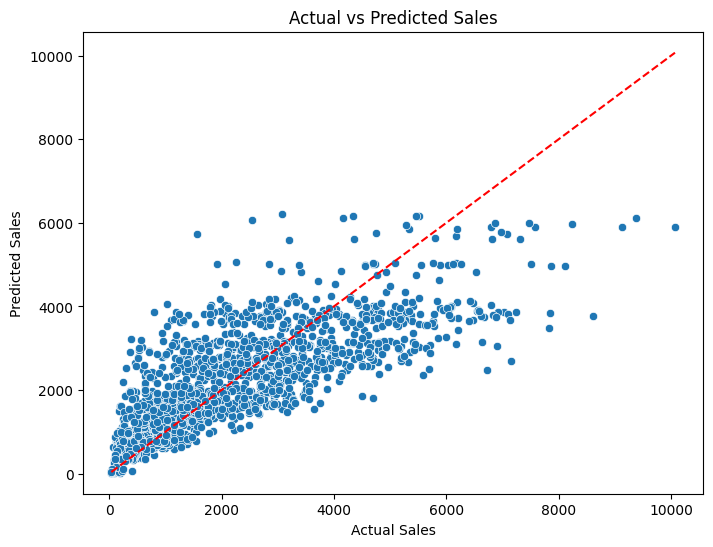

In [64]:
# Predict on the test set
y_pred = best_cat_model.predict(X_test)

# Plotting Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


## Residual Analysis


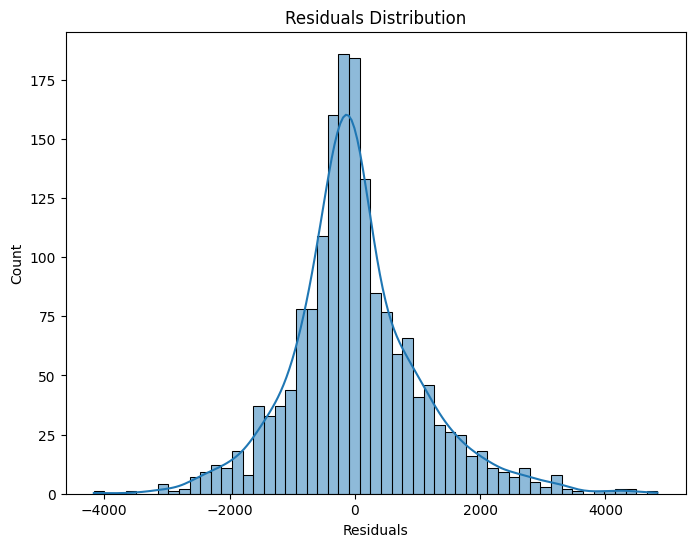

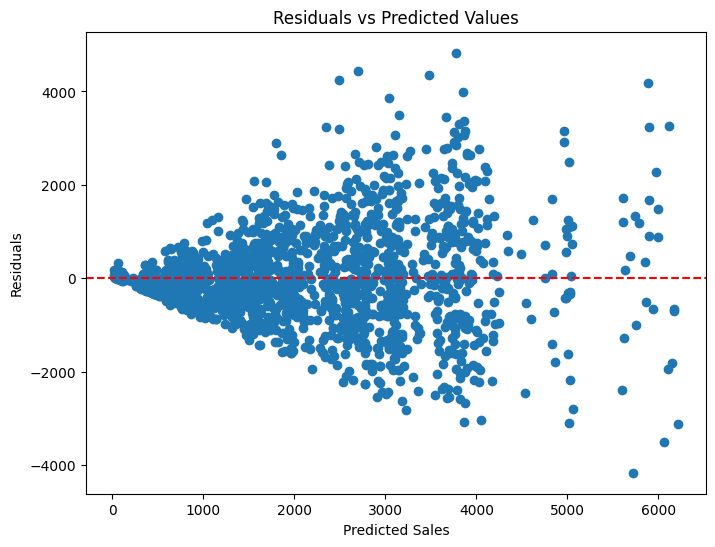

In [65]:
# Residuals
residuals = y_test - y_pred

# Plotting residuals distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()

# Residuals vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


## Learning Curve


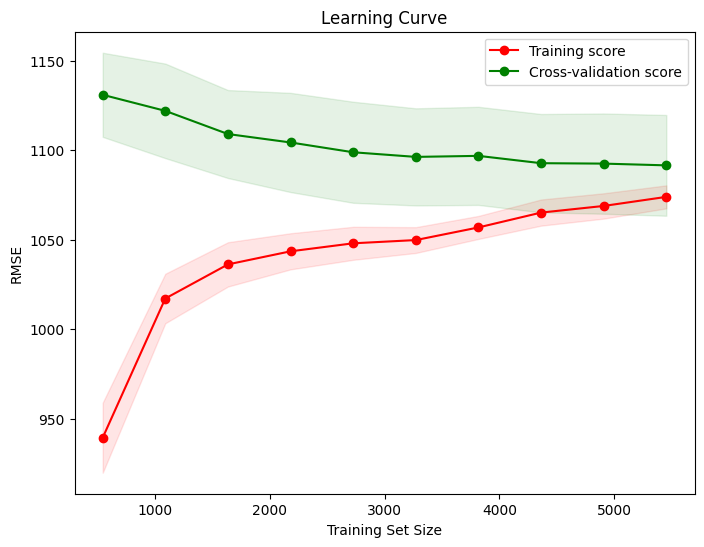

In [66]:

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    best_cat_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()


## Cross-Validation Results


In [67]:
# Cross-validation on the best model
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_cat_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'
)

print("Cross-Validation RMSE Scores:")
print(-cv_scores)
print(f"Mean CV RMSE: {-cv_scores.mean():.4f}")
print(f"Standard Deviation of CV RMSE: {cv_scores.std():.4f}")


Cross-Validation RMSE Scores:
[1099.96771101 1043.36970064 1092.39912981 1091.76402887 1130.5015325 ]
Mean CV RMSE: 1091.6004
Standard Deviation of CV RMSE: 27.9649


## Prediction Error Plot


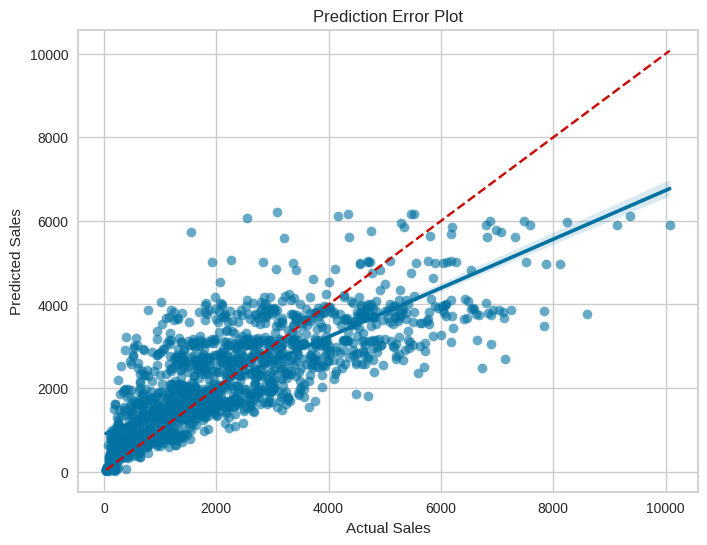

In [71]:
# Predict on the test set
y_pred = best_cat_model.predict(X_test)

# Create a DataFrame with actual and predicted values
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting
plt.figure(figsize=(8, 6))
sns.regplot(x='Actual', y='Predicted', data=pred_df, scatter_kws={'alpha':0.6})
plt.title('Prediction Error Plot')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
